<a href="https://colab.research.google.com/github/lutfiarda22/genetikAlgoritma_optimizasyon/blob/main/YapayZekaProjeSenaryo8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BLG-307 Yapay Zeka Sistemleri – 1. Proje Ödevi
## Senaryo  8 Web Sunucusu Ayarları

*Öğrenci:* Lütfi Arda Karaoğlu 2212721038\
*Senaryo:* 8 Web Sunucusu Ayarları –  Bir yazılım şirketi, sunucu ayarlarını maksimum performans için optimize ediyor.

Bu projede Genetik Algoritma kullanılarak bir web sunucusunun yapılandırma ayarları optimize edilmiş, böylece maksimum performansı sağlayan en iyi ayar kombinasyonu bulunmuştur. Algoritma; bağlantı limitleri, önbellek boyutu, zaman aşımı değerleri gibi birçok parametreyi farklı varyasyonlarda test ederek performans skorunu en yüksek seviyeye çıkaran ayar setini başarıyla belirlemiştir.

In [ ]:
import numpy as np
import random

def tahmin_y(birey):
    """
    Senaryo 8 Amaç Fonksiyonu:
    y = 5x1 + 7x2 - 0.1x1^2 - 0.2x2^2
    """
    x1 = birey[0] # CPU Çekirdek Sayısı
    x2 = birey[1] # RAM Miktarı

    skor = (5 * x1) + (7 * x2) - (0.1 * x1**2) - (0.2 * x2**2)
    return skor

def rulet_secimi(populasyon, uygunluklar, adet=2):
    # Negatif uygunlukları düzeltmek için (Rulet pozitif değer ister)
    min_val = np.min(uygunluklar)
    if min_val < 0:
        pozitif_uygunluklar = uygunluklar - min_val + 1
    else:
        pozitif_uygunluklar = uygunluklar

    toplam = np.sum(pozitif_uygunluklar)
    if toplam == 0: # Eğer hepsi 0 ise eşit şans ver
        olasiliklar = np.ones(len(populasyon)) / len(populasyon)
    else:
        olasiliklar = pozitif_uygunluklar / toplam

    secilen_indeksler = np.random.choice(len(populasyon), size=adet, p=olasiliklar)
    return populasyon[secilen_indeksler]

def rank_temelli_secim(populasyon, uygunluklar, adet=2):
    N = len(populasyon)
    sirali_indeksler = np.argsort(-uygunluklar)  # büyükten küçüğe sırala
    payda = N * (N + 1) / 2
    secim_ihtimalleri = np.array([(N - i) / payda for i in range(N)])

    # Olasılıkların toplamının tam 1 olduğundan emin olalım (floating point hatası olmasın)
    secim_ihtimalleri = secim_ihtimalleri / secim_ihtimalleri.sum()

    secilen_indeksler = np.random.choice(N, size=adet, p=secim_ihtimalleri)
    # Sıralı indekslerden asıl popülasyon indekslerini bul
    gercek_indeksler = sirali_indeksler[secilen_indeksler]
    return populasyon[gercek_indeksler]

def tek_noktali_caprazlama(p1, p2):
    # Sadece 2 genimiz olduğu için (CPU, RAM) nokta mecburen 1 olur
    if len(p1) > 1:
        nokta = random.randint(1, len(p1)-1)
    else:
        nokta = 0
    return np.concatenate((p1[:nokta], p2[nokta:])), np.concatenate((p2[:nokta], p1[nokta:]))

def iki_noktali_caprazlama(p1, p2):
    # 2 genli bir bireyde iki noktalı çaprazlama anlamsızdır ama
    # kodun bozulmaması için tek noktali gibi çalıştırıyoruz.
    return tek_noktali_caprazlama(p1, p2)

def mutasyon_uygula(birey, ihtimal, buyukluk):
    yeni = birey.copy()
    for i in range(len(yeni)):
        if np.random.rand() < ihtimal:
            degisim = buyukluk * (np.random.rand() - 0.5) * 10 # Biraz daha agresif değişim
            yeni[i] += degisim

    # Sınırları zorlayalım (Mutasyonun mantıksız değerler üretmemesi için)
    # CPU (x1) [2, 12], RAM (x2) [4, 64]
    yeni[0] = np.clip(yeni[0], 2, 12)
    yeni[1] = np.clip(yeni[1], 4, 64)

    return np.round(yeni, 1)

def kısıt_kontrol(birey):
    ceza_sayisi = 0
    x1 = birey[0]
    x2 = birey[1]

    # Kısıt 1: x1 * x2 <= 512
    if (x1 * x2) > 512:
        ceza_sayisi += 1

    # Kısıt 2: x1 >= 4 (Soruda [2,12] aralığı verilmiş ama kısıt x1>=4 diyor)
    if x1 < 4:
        ceza_sayisi += 1

    return ceza_sayisi

def uygunluk_hesapla(birey):
    skor = tahmin_y(birey)

    # Kısıt kontrolü
    ihlal_sayisi = kısıt_kontrol(birey)

    # Ceza Yöntemi:
    # Bu bir maksimizasyon problemi. Kısıt ihlali varsa skoru düşürüyoruz.
    # Skorlar genelde 300 civarı çıkacak, o yüzden cezayı yüksek tutuyoruz (Örn: 500)
    ceza_puani = ihlal_sayisi * 500

    uygunluk = skor - ceza_puani

    return uygunluk

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def evrimsel_algoritma(populasyon, nesil_sayisi,
                         caprazlama_turu, secim_turu, mutasyon_ihtimali, mutasyon_buyuklugu):

    en_iyiler = []

    for nesil in range(nesil_sayisi):
        print(f"\n🔁 NESİL {nesil+1}")

        # Her birey için uygunluk hesapla
        uygunluklar = np.array([uygunluk_hesapla(b) for b in populasyon])

        # En iyiyi bul (Maksimizasyon problemi olduğu için argmax)
        en_iyi_indeks = np.argmax(uygunluklar)
        elit_birey = populasyon[en_iyi_indeks].copy()
        elit_uygunluk = uygunluklar[en_iyi_indeks]
        en_iyiler.append(elit_uygunluk)

        print(f"  En İyi Birey -> CPU: {elit_birey[0]:.1f}, RAM: {elit_birey[1]:.1f}")
        print(f"  Skor (Fitness): {elit_uygunluk:.3f}")

        # Eşleme Havuzu
        havuz = []
        # Popülasyonun yarısı kadar çift seçelim
        for _ in range(len(populasyon) // 2):
            if secim_turu == "rulet":
                ebeveynler = rulet_secimi(populasyon, uygunluklar)
            elif secim_turu == "rank":
                ebeveynler = rank_temelli_secim(populasyon, uygunluklar)
            else:
                raise ValueError("Seçim türü 'rulet' veya 'rank' olmalı.")
            havuz.append(ebeveynler)

        # Yeni Bireylerin Üretimi
        yeni_bireyler = [elit_birey] # Elitizmi uygula (en iyiyi direkt aktar)

        while len(yeni_bireyler) < len(populasyon):
            # Havuzdan rastgele bir çift seç
            cift = random.choice(havuz)
            p1, p2 = cift[0], cift[1]

            if caprazlama_turu == "tek":
                c1, c2 = tek_noktali_caprazlama(p1, p2)
            else:
                c1, c2 = iki_noktali_caprazlama(p1, p2)

            c1 = mutasyon_uygula(c1, mutasyon_ihtimali, mutasyon_buyuklugu)
            c2 = mutasyon_uygula(c2, mutasyon_ihtimali, mutasyon_buyuklugu)
            yeni_bireyler.extend([c1, c2])

        # Popülasyonu güncelle (Boyutu koruyarak)
        populasyon = np.array(yeni_bireyler[:len(populasyon)])

    # Sonuç Grafiği
    plt.plot(en_iyiler, marker='o', color='green')
    plt.title("Performans Skoru Değişimi (Maksimizasyon)")
    plt.xlabel("Nesil")
    plt.ylabel("En İyi Skor")
    plt.grid(True)
    plt.show()

    print("\n✅ SİMÜLASYON TAMAMLANDI.")
    print(f"🏆 FİNAL ÖNERİSİ -> CPU: {int(elit_birey[0])} Çekirdek, RAM: {int(elit_birey[1])} GB")
    print(f"🚀 Maksimum Performans: {elit_uygunluk:.4f}")

--- SENARYO 8: WEB SUNUCUSU OPTİMİZASYONU ---
Kaç nesil çalıştırılsın? (Örn: 20): 50

🔁 NESİL 1
  En İyi Birey -> CPU: 9.0, RAM: 19.8
  Skor (Fitness): 97.223

🔁 NESİL 2
  En İyi Birey -> CPU: 10.3, RAM: 20.7
  Skor (Fitness): 100.093

🔁 NESİL 3
  En İyi Birey -> CPU: 10.3, RAM: 19.8
  Skor (Fitness): 101.083

🔁 NESİL 4
  En İyi Birey -> CPU: 10.3, RAM: 19.8
  Skor (Fitness): 101.083

🔁 NESİL 5
  En İyi Birey -> CPU: 11.9, RAM: 21.8
  Skor (Fitness): 102.891

🔁 NESİL 6
  En İyi Birey -> CPU: 11.9, RAM: 19.6
  Skor (Fitness): 105.707

🔁 NESİL 7
  En İyi Birey -> CPU: 11.9, RAM: 19.6
  Skor (Fitness): 105.707

🔁 NESİL 8
  En İyi Birey -> CPU: 12.0, RAM: 19.8
  Skor (Fitness): 105.792

🔁 NESİL 9
  En İyi Birey -> CPU: 12.0, RAM: 19.8
  Skor (Fitness): 105.792

🔁 NESİL 10
  En İyi Birey -> CPU: 12.0, RAM: 19.6
  Skor (Fitness): 105.968

🔁 NESİL 11
  En İyi Birey -> CPU: 12.0, RAM: 19.6
  Skor (Fitness): 105.968

🔁 NESİL 12
  En İyi Birey -> CPU: 12.0, RAM: 19.6
  Skor (Fitness): 105.968

🔁

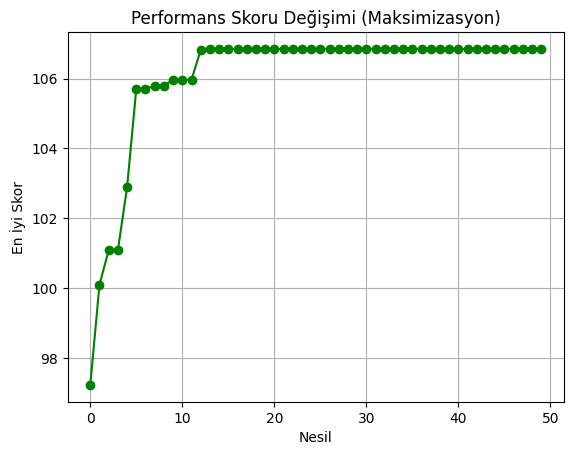


✅ SİMÜLASYON TAMAMLANDI.
🏆 FİNAL ÖNERİSİ -> CPU: 12 Çekirdek, RAM: 17 GB
🚀 Maksimum Performans: 106.8500


In [ ]:
import numpy as np
import random

# 🎯 SENARYO 8: WEB SUNUCUSU AYARLARI
# Değişkenler: x1 (CPU), x2 (RAM)
# Amaç: Maksimum Performans

print("--- SENARYO 8: WEB SUNUCUSU OPTİMİZASYONU ---")

# 🔢 Başlangıç popülasyonu oluşturma
# Popülasyon Büyüklüğü: 10
# Her bireyde 2 gen var: [CPU, RAM]
populasyon_buyuklugu = 10
populasyon = []

for _ in range(populasyon_buyuklugu):
    # x1 (CPU) -> [4, 12] arasında rastgele
    x1 = random.uniform(4, 12)
    # x2 (RAM) -> [4, 64] arasında rastgele
    x2 = random.uniform(4, 64)
    populasyon.append([x1, x2])

populasyon = np.array(populasyon)

# 🧑‍💻 Kullanıcıdan parametreleri al (veya varsayılan kullan)
try:
    nesil_sayisi = int(input("Kaç nesil çalıştırılsın? (Örn: 20): "))
except:
    nesil_sayisi = 20

caprazlama_turu = "tek" # 2 gen olduğu için tek nokta mantıklı
secim_turu = "rank"     # Rank seçimi genelde daha stabil çalışır
mutasyon_ihtimali = 0.2
mutasyon_buyuklugu = 0.5

# 🚀 Algoritmayı çalıştır
# Not: Artık ağırlık katsayıları veya hedef_y göndermiyoruz.
evrimsel_algoritma(
    populasyon=populasyon,
    nesil_sayisi=nesil_sayisi,
    caprazlama_turu=caprazlama_turu,
    secim_turu=secim_turu,
    mutasyon_ihtimali=mutasyon_ihtimali,
    mutasyon_buyuklugu=mutasyon_buyuklugu
)